# T-DEV-810 - Boosted trees with XGBoost

    Jonathan Khalifa
    Valentin Noel
    Fabrice Sumsa
    Bastien Angles
    Kevan Sadeghi

**Current accuracy : 75%**

In [1]:
# IMPORTS

import glob
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from IPython.display import clear_output
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,confusion_matrix
import itertools
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

### Global vars
- Common batch size values : 16 - 32 - 64 - 128
- Train size sample for the total amount of equally distributed images before data augmentation.
- Max train sample size is 4023. max val to have equally distributed image categories.
- Image size(width, height). according to this studdy https://pubs.rsna.org/doi/full/10.1148/ryai.2019190015 the optimal size is 256x256. But lacking enough calculation power, we will remain at 64x64 while still getting decent results.

In [2]:
TRAIN_SAMPLE_SIZE = 4023
IMG_SIZE = 64

PATH_TRAIN_VIR = "../chest_Xray/train/PNEUMONIA/*virus*.*"
PATH_TRAIN_BACT = "../chest_Xray/train/PNEUMONIA/*bacteria*.*"
PATH_TRAIN_NORM = "../chest_Xray/train/NORMAL/*"
PATH_TEST_NORM = "../chest_Xray/test/NORMAL/*"
PATH_TEST_VIR = "../chest_Xray/test/PNEUMONIA/*virus*.*"
PATH_TEST_BACT = "../chest_Xray/test/PNEUMONIA/*bacteria*.*"

PATH_EXAMPLE_IMAGE1 = "../chest_Xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg"
PATH_EXAMPLE_IMAGE2 = "../chest_Xray/val/NORMAL/NORMAL2-IM-1442-0001.jpeg"
PATH_EXAMPLE_IMAGE3 = "../chest_Xray/train/PNEUMONIA/person995_virus_1676.jpeg"

### Load the Dataset
- We plot the distribution of our image's labels to see the disparities.
- The plot reveals that we will need to redistribute the datasets for better training.

We have  1345  viral pneumonia train files
We have  1341  normal train files
We have  2530  bacterial pneumonia train files
We have  148  viral pneumonia test files
We have  234  normal test files
We have  242  bacterial pneumonia test files


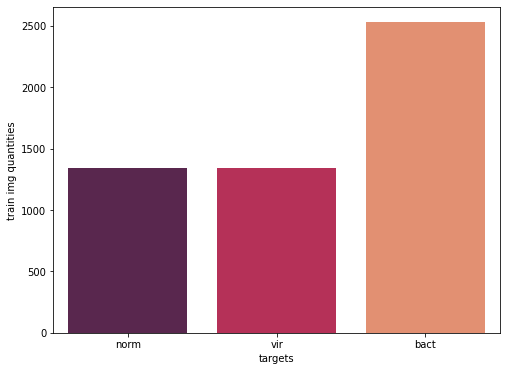

In [3]:
# Load the training files
files_train_vir = glob.glob(PATH_TRAIN_VIR)
files_train_bact = glob.glob(PATH_TRAIN_BACT)
files_train_norm = glob.glob(PATH_TRAIN_NORM)
files_test_norm = glob.glob(PATH_TEST_NORM)
files_test_vir = glob.glob(PATH_TEST_VIR)
files_test_bact = glob.glob(PATH_TEST_BACT)

# Shuffle
random.shuffle(files_train_vir)
random.shuffle(files_train_bact)
random.shuffle(files_train_norm)
random.shuffle(files_test_vir)
random.shuffle(files_test_bact)
random.shuffle(files_test_norm)


print('We have ', len(files_train_vir) ,' viral pneumonia train files')
print('We have ', len(files_train_norm) ,' normal train files')
print('We have ', len(files_train_bact) ,' bacterial pneumonia train files')
print('We have ', len(files_test_vir) ,' viral pneumonia test files')
print('We have ', len(files_test_norm) ,' normal test files')
print('We have ', len(files_test_bact) ,' bacterial pneumonia test files')

        
# Distrib plot 
x = ('norm', 'vir', 'bact')
y = [len(files_train_norm),len(files_train_vir),len(files_train_bact)]


df2 = pd.DataFrame({'targets':x,
                    'train img quantities':y})
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x = 'targets',
            y = 'train img quantities',
            data = df2,
            ax=ax,
            palette = "rocket")
 
plt.show()

### We make a new training batch with equaly distributed image categories. 
- Similar quantities of each category will make better training.
- TRAIN_SAMPLE_SIZE can at most be twice the val of the cat with the less images : min([len(files_train_sick),len(files_train_norm)])

Total images in sample equally distributed dataset :  4023


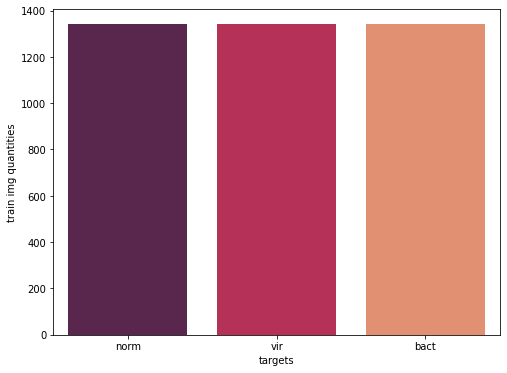

In [4]:
# We will also make a smaller equally distributed dataset for testing purposes
train_subsample_size = int(TRAIN_SAMPLE_SIZE/3)
files_train_sample = files_train_norm[:train_subsample_size] + files_train_vir[:train_subsample_size] + files_train_bact[:train_subsample_size]
random.shuffle(files_train_sample)


t = min([len(files_test_bact),len(files_test_norm),len(files_test_vir)])
files_test_final = files_test_norm[:t] + files_test_vir[:t] + files_test_bact[:t]
random.shuffle(files_test_final)


# Distrib plot 
x = ('norm', 'vir', 'bact')
y = [len(files_train_norm[:train_subsample_size]),
     len(files_train_vir[:train_subsample_size]),
     len(files_train_bact[:train_subsample_size])]

print('Total images in sample equally distributed dataset : ', len(files_train_sample))

df2 = pd.DataFrame({'targets':x,
                    'train img quantities':y})
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x = 'targets',
            y = 'train img quantities',
            data = df2,
            ax=ax,
            palette = "rocket")
plt.show()

### Time to fix our datasets
#### For this data to be usefull, we will have to do the following :
- create the labels 
- put all the images to the same size
- put all the images to Gray Scale
- enhance our contrasts with CLAHE (Contrast-Limited Adaptive Histogram Equalization)

In [5]:
# Label, resize and RGB
def fixData(dataset):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)) 
    y_data = []
    x_data = []
    for file in dataset:
        image = cv2.imread(file)
        image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY) ### CLAHE
        image = clahe.apply(image) ### CLAHE
        image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

        data = np.array(image)
        x_data.append(data)
        
        # LABELS
        if("virus" in file):
            target = 1
        elif("bacteria" in file):
            target = 2
        else:
            target = 0

        y_data.append(target)    
    x_data = np.asarray(x_data)    
    y_data = np.asarray(y_data)
    return (x_data,y_data)


# Training images
(x_train_sample, y_train_sample) = fixData(files_train_sample)

# Testing images
(x_test, y_test) = fixData(files_test_final)


# Stats to be printed
print("Features train sample shape : ", x_train_sample.shape)
print("Targets train sample shape  : ", y_train_sample.shape)
print("Features test shape         : ", x_test.shape)
print("Targets test shape          : ", y_test.shape)


# Normalize data
def normData(data):
    xmax = data.max()
    data = data / xmax
    return data


print('Before normalization        : min={}, max={}'.format(x_train_sample.min(), x_train_sample.max()))
x_train_sample = normData(x_train_sample)
x_test = normData(x_test)
print('After normalisation         : min={}, max={}'.format(x_train_sample.min(), x_train_sample.max()))

Features train sample shape :  (4023, 64, 64, 3)
Targets train sample shape  :  (4023,)
Features test shape         :  (444, 64, 64, 3)
Targets test shape          :  (444,)
Before normalization        : min=0, max=255
After normalisation         : min=0.0, max=1.0


### Flaten data

Flatten the images to have only a one-dimensional matrix for modeling an image.<br>
Each value of the matrix represents an RGB value of each pixel of the image. 
<br>
3 * 64 * 64 = **3 RGB values** per pixel * **64 pixels on width** * **64 pixels on height**

In [6]:
RESHAPED = 3 * IMG_SIZE * IMG_SIZE
x_train_sample = x_train_sample.reshape(-1, RESHAPED)
x_test = x_test.reshape(-1, RESHAPED)

x_train_sample = x_train_sample.astype('float32')
x_test = x_test.astype('float32')

# Define XGBoost model for classification without optimized parameters

**learning_rate** = 0.01, boosting learning rate used to prevent overfiting<br>
**max_depth** = 24, maximum tree depth<br>
**n_estimators** = 30, numbers of trees adding more trees does not improve the performance of the model<br>
**objective** = multi:softmax, because we want a multiclass classification<br>
**use_label_encoder** = False, we not use One Hot Encoding in this case

In [7]:
model = xgb.XGBClassifier(learning_rate=0.01, max_depth=24, n_estimators=30,
                        n_jobs=4, objective='multi:softmax', use_label_encoder=False)

In [8]:
model.fit(x_train_sample, y_train_sample, verbose=True)

[11:50:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=24,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=30, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [9]:
# Single axis Target names for plotting
def tgtNames(targets):
    target_names = []
    for target in targets:
        if(target == 0):
            target_names.append("Norm")
        elif(target == 1):
            target_names.append("Vir")
        elif(target == 2):
            target_names.append("Bact")
    return target_names

# Test model and output metrics
predictions = model.predict(x_test)

y_test_names = tgtNames(y_test)
y_pred_names = tgtNames(predictions)

print(classification_report(y_test_names,y_pred_names))

              precision    recall  f1-score   support

        Bact       0.72      0.78      0.75       148
        Norm       0.80      0.54      0.65       148
         Vir       0.62      0.77      0.69       148

    accuracy                           0.70       444
   macro avg       0.71      0.70      0.70       444
weighted avg       0.71      0.70      0.70       444



# Tuning the hyperparameters

## Find the best learning rate

To determine the best learning rate, we check the lowest value of the log-loss.<br>
Log-loss is indicative of how close the prediction probability is to the expected value.<br>
The more the predicted probability matches from the actual value, the lower is the log-loss value.<br><br>
For this test, we use 4 learning rate between 0.01 and 0.2.

In [10]:
xgb_model = xgb.XGBClassifier()
learning_rates = [0.01, 0.05, 0.1, 0.2]

parameters = {'objective':['multi:softmax'],
              'learning_rate': learning_rates,
              'max_depth': [4],
              'n_estimators': [100],
              'use_label_encoder': [False]}


clf = GridSearchCV(xgb_model, parameters, n_jobs=-1, 
                   cv=StratifiedKFold(n_splits=2, shuffle=True), 
                   scoring='neg_log_loss',
                   refit=True,
                   verbose=1)

clf.fit(x_train_sample, y_train_sample)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[12:16:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     miss...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
              

Best Mean Loss: -0.531088 using learning rate of 0.1
Mean Loss: -0.803614 (Standard deviation Loss: 0.001609) with learning rate of 0.01
Mean Loss: -0.572820 (Standard deviation Loss: 0.009355) with learning rate of 0.05
Mean Loss: -0.531088 (Standard deviation Loss: 0.013779) with learning rate of 0.1
Mean Loss: -0.558865 (Standard deviation Loss: 0.013480) with learning rate of 0.2


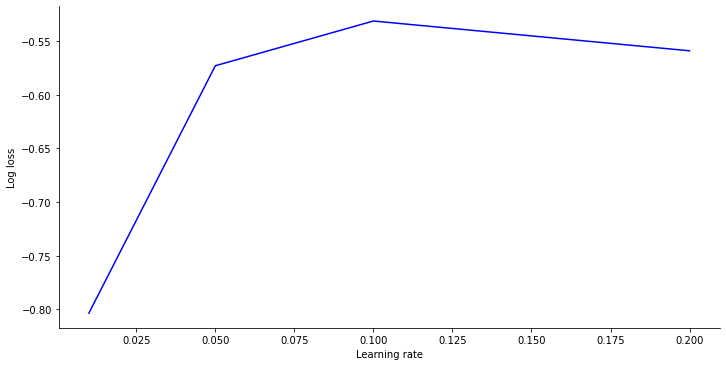

In [11]:
# Summarize results
print("Best Mean Loss: %f using learning rate of %s" % (clf.best_score_, clf.best_params_['learning_rate']))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean Loss: %f (Standard deviation Loss: %f) with learning rate of %r" % (mean, stdev, param['learning_rate']))
    
# Plot results
sns.relplot(data=pd.DataFrame({'Log loss': means,
                   'Learning rate': learning_rates}),
            y='Log loss',
            x='Learning rate',
            kind='line', 
            height=5,
            aspect=2,
            color='blue')

## Find the best max_depth

To determine the best max_depth of trees, we check the lowest value of the log-loss.<br>
For this test, we use 4 max_depth between 2 and 8.

In [12]:
xgb_model = xgb.XGBClassifier()
max_depths = [2, 4, 6, 8]

parameters = {'objective':['multi:softmax'],
              'learning_rate': [0.1],
              'max_depth': max_depths,
              'n_estimators': [100],
              'use_label_encoder': [False]}


clf = GridSearchCV(xgb_model, parameters, n_jobs=-1, 
                   cv=StratifiedKFold(n_splits=2, shuffle=True), 
                   scoring='neg_log_loss',
                   refit=True,
                   verbose=1)

clf.fit(x_train_sample, y_train_sample)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[12:49:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     miss...
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                           

Best Mean Loss: -0.536617 using max_depth of 4
Mean Loss: -0.574547 (Standard deviation Loss: 0.007506) with max_depth of 2
Mean Loss: -0.536617 (Standard deviation Loss: 0.010102) with max_depth of 4
Mean Loss: -0.576610 (Standard deviation Loss: 0.014014) with max_depth of 6
Mean Loss: -0.606488 (Standard deviation Loss: 0.004274) with max_depth of 8


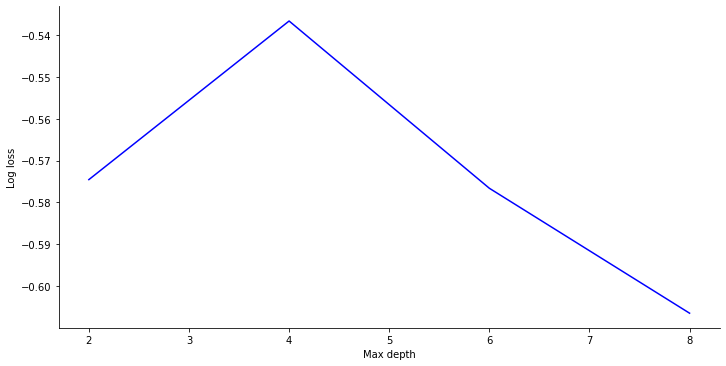

In [13]:
# Summarize results
print("Best Mean Loss: %f using max_depth of %s" % (clf.best_score_, clf.best_params_['max_depth']))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean Loss: %f (Standard deviation Loss: %f) with max_depth of %r" % (mean, stdev, param['max_depth']))
    
# Plot results
sns.relplot(data=pd.DataFrame({'Log loss': means,
                   'Max depth': max_depths}),
            y='Log loss',
            x='Max depth',
            kind='line', 
            height=5,
            aspect=2,
            color='blue')

## Find the best number of estimators

To determine the best number of estimators, so the best numbers of trees, we check the lowest value of the log-loss.<br>
For this test, we use 4 max_depth between 50 and 200.

In [14]:
xgb_model = xgb.XGBClassifier()
n_estimators = [50, 100, 150, 200]

parameters = {'objective':['multi:softmax'],
              'learning_rate': [0.1],
              'max_depth': [4],
              'n_estimators': n_estimators,
              'use_label_encoder': [False]}


clf = GridSearchCV(xgb_model, parameters, n_jobs=-1, 
                   cv=StratifiedKFold(n_splits=2, shuffle=True), 
                   scoring='neg_log_loss',
                   refit=True,
                   verbose=1)

clf.fit(x_train_sample, y_train_sample)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[13:18:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     miss...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
              

Best Mean Loss: -0.531227 using n_estimators of 100
Mean Loss: -0.573023 (Standard deviation Loss: 0.004175) with n_estimators of 50
Mean Loss: -0.531227 (Standard deviation Loss: 0.002743) with n_estimators of 100
Mean Loss: -0.531303 (Standard deviation Loss: 0.001687) with n_estimators of 150
Mean Loss: -0.542106 (Standard deviation Loss: 0.005267) with n_estimators of 200


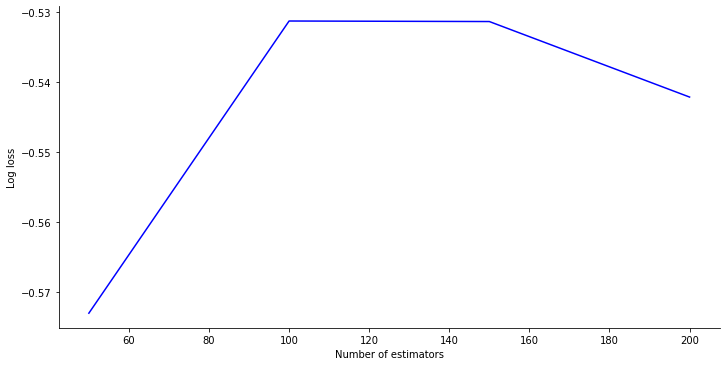

In [15]:
# Summarize results
print("Best Mean Loss: %f using n_estimators of %s" % (clf.best_score_, clf.best_params_['n_estimators']))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean Loss: %f (Standard deviation Loss: %f) with n_estimators of %r" % (mean, stdev, param['n_estimators']))
    
# Plot results
sns.relplot(data=pd.DataFrame({'Log loss': means,
                   'Number of estimators': n_estimators}),
            y='Log loss',
            x='Number of estimators',
            kind='line', 
            height=5,
            aspect=2,
            color='blue')

## Define XGBoost model for classification with optimized parameters

**learning_rate** = 0.01, boosting learning rate used to prevent overfiting<br>
**max_depth** = 4, maximum tree depth<br>
**n_estimators** = 100, numbers of trees adding more trees does not improve the performance of the model<br>
**objective** = multi:softmax, because we want a multiclass classification<br>
**use_label_encoder** = False, we not use One Hot Encoding in this case

In [16]:
# Set up model
model = xgb.XGBClassifier(learning_rate=0.1, max_depth=4, n_estimators=100,
                        n_jobs=4, objective='multi:softmax', use_label_encoder=False)

### Train the model with the train dataset

In [17]:
model.fit(x_train_sample, y_train_sample, verbose=True)

[13:21:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

### Analyse results with the test dataset

              precision    recall  f1-score   support

        Bact       0.78      0.91      0.84       148
        Norm       0.94      0.51      0.66       148
         Vir       0.64      0.82      0.72       148

    accuracy                           0.75       444
   macro avg       0.78      0.75      0.74       444
weighted avg       0.78      0.75      0.74       444



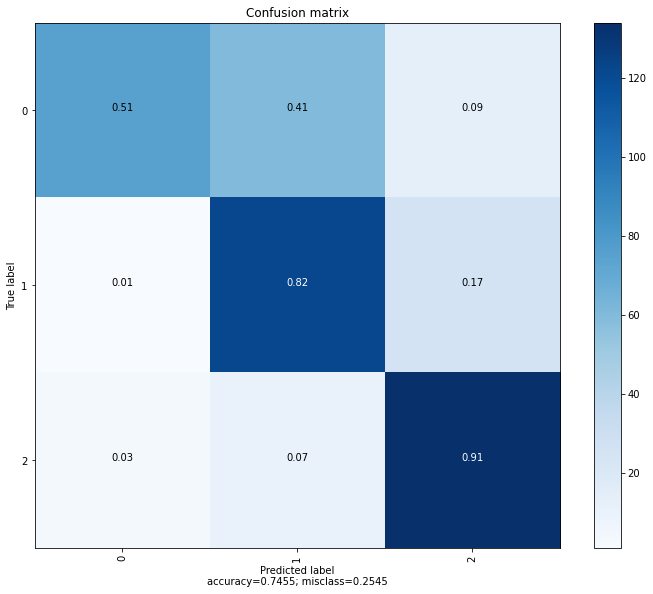

In [18]:
# To plot the confusions matrix
def plot_confusion_matrix(y_true,y_pred,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          figsize=(10, 8),
                          digit_format='{:0.2f}',
                          save_as='auto'):
    """
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    """
    cm = confusion_matrix( y_true,y_pred, normalize=None, labels=target_names)
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, digit_format.format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# Test model and output metrics
predictions = model.predict(x_test)

y_test_names = tgtNames(y_test)
y_pred_names = tgtNames(predictions)

print(classification_report(y_test_names,y_pred_names))
plot_confusion_matrix(y_test, predictions, range(3), normalize=True)